In [2]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
from PIL import Image
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Check if a GPU is available
if torch.cuda.is_available():
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU is available: {gpu_name}")
else:
    print("No GPU available, using CPU.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


GPU is available: Tesla T4
cuda:0


In [1]:
!pip install torchsummary

In [3]:
import pickle
import json
import os

basePath = '/kaggle/input/pose-data/pose_data'
img_data_path = basePath+"/imgs/"

def get_folder_size(folder_path):
    total_size = 0
    file_count = 0

    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
            file_count += 1

    return file_count

num_files = get_folder_size(img_data_path)
print(num_files)


with open(basePath+'/syn.json', 'r') as f:
    syn_data = json.load(f)
print(syn_data)

ego_start_frame = syn_data['ego']
ext_start_frame = syn_data['ext']

with open(basePath+'/local_pose_gt.pkl', 'rb') as f:
    pose_gt_data = pickle.load(f)
    
train_size = len(pose_gt_data)*0.80
test_size = len(pose_gt_data) - train_size

#print(pose_gt_data[0])
image_path_list = []
image_list = []
gt_pose_list = []
test_image_list = []
test_gt_pose_list = []
depth_path_list = []
depth_image_list = []
gt_pose_list = []
gt_data_list = []
count = 0
for pose_gt_item in pose_gt_data:
    count = count+1
    ext_id = pose_gt_item['ext_id']
    ego_pose_gt = pose_gt_item['ego_pose_gt']
    if ego_pose_gt is None:
        continue
    ego_id = ext_id - ext_start_frame + ego_start_frame
    egocentric_image_name = "img_%06d.jpg" % ego_id

    image_path = os.path.join(img_data_path, egocentric_image_name)
    if not os.path.exists(image_path):
        continue
    image_path_list.append(image_path)
    image = Image.open(image_path)
    #if count<=train_size:
    image_list.append(image)
    gt_pose_list.append(ego_pose_gt)


  
print("Dataset length: {}".format(len(image_list)))


2375
{'ego': 128, 'ext': 189}
Dataset length: 2174


In [4]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Combine image paths and labels into tuples
data = list(zip(image_path_list, gt_pose_list))

# Split the data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# Unzip train, validation, and test data into separate lists
train_image_paths, train_labels = zip(*train_data)
test_image_paths, test_labels = zip(*test_data)

# Print the lengths of each set
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Define transformations for your images (you can customize these)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # example normalization values
])

# Create custom datasets for training, validation, and testing
train_dataset = CustomDataset(train_image_paths, train_labels, transform=transform)
test_dataset = CustomDataset(test_image_paths, test_labels, transform=transform)

# Create DataLoader instances for batch processing
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train set size: 1739
Test set size: 435


In [5]:
num_joints = 15  # Adjust based on your task
class CustomResNet50(nn.Module):
    def __init__(self, num_joints):
        super(CustomResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, blocks=3)
        self.layer2 = self._make_layer(256, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(512, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(1024, 512, blocks=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 3 * num_joints)  # Adjust the output dimension

    def _make_layer(self, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(Bottleneck(inplanes, planes, stride))
        inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(Bottleneck(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.stride != 1 or x.size(1) != out.size(1):
            residual = out

        out += residual
        out = self.relu(out)

        return out

# Initialize the custom model

model = CustomResNet50(num_joints)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the same device

# Print the model summary using torchsummary
summary(model, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
       Bottleneck-14          [-1, 256,

In [ ]:
num_joints = 15  # Adjust based on your task
class CustomResNet50(nn.Module):
    def __init__(self, num_joints):
        super(CustomResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, blocks=3)
        self.layer2 = self._make_layer(256, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(512, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(1024, 512, blocks=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 3 * num_joints)  # Adjust the output dimension

    def _make_layer(self, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(Bottleneck(inplanes, planes, stride))
        inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(Bottleneck(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.stride != 1 or x.size(1) != out.size(1):
            residual = out

        out += residual
        out = self.relu(out)

        return out

# Initialize the custom model

model = CustomResNet50(num_joints)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the same device

# Print the model summary using torchsummary
summary(model, (3, 1280,1024))

K-Fold


Fold 1/4
Fold 1/4, Epoch 1/10, Training Loss: 0.0593, Accuracy: 4.48%, MPJPE: 0.6568
Fold 1/4, Epoch 2/10, Training Loss: 0.0091, Accuracy: 26.66%, MPJPE: 0.2763
Fold 1/4, Epoch 3/10, Training Loss: 0.0064, Accuracy: 38.40%, MPJPE: 0.2287
Fold 1/4, Epoch 4/10, Training Loss: 0.0050, Accuracy: 45.67%, MPJPE: 0.2006
Fold 1/4, Epoch 5/10, Training Loss: 0.0042, Accuracy: 50.73%, MPJPE: 0.1833
Fold 1/4, Epoch 6/10, Training Loss: 0.0036, Accuracy: 54.37%, MPJPE: 0.1695
Fold 1/4, Epoch 7/10, Training Loss: 0.0031, Accuracy: 57.12%, MPJPE: 0.1598
Fold 1/4, Epoch 8/10, Training Loss: 0.0027, Accuracy: 61.03%, MPJPE: 0.1493
Fold 1/4, Epoch 9/10, Training Loss: 0.0025, Accuracy: 63.60%, MPJPE: 0.1426
Fold 1/4, Epoch 10/10, Training Loss: 0.0022, Accuracy: 66.14%, MPJPE: 0.1357
Fold 1/4, Validation Loss: 0.0118, Validation Accuracy: 58.02%, Validation MPJPE: 0.1569
Fold 2/4
Fold 2/4, Epoch 1/10, Training Loss: 0.0024, Accuracy: 62.44%, MPJPE: 0.1433
Fold 2/4, Epoch 2/10, Training Loss: 0.0021, A

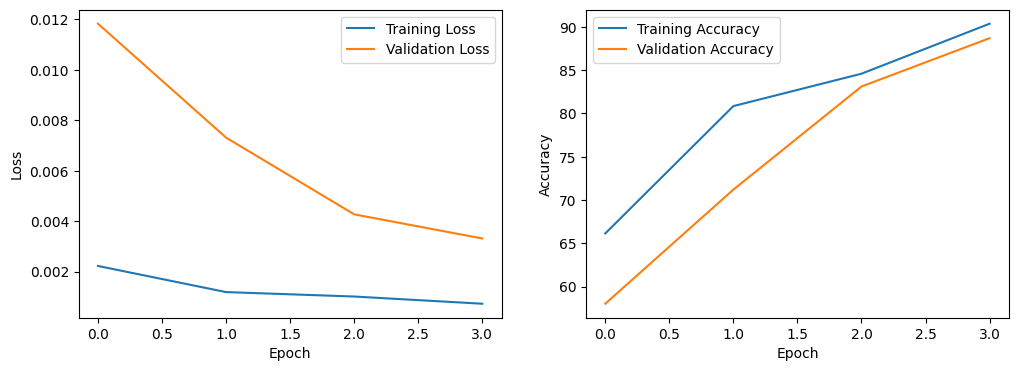

In [6]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np

# ... (Your model and dataset code)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your loss function
criterion = torch.nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# K-fold cross-validation
num_epochs = 10
accumulation_steps = 4
distance_threshold = 0.15 # Adjust this threshold as needed
k_folds = 4  # Change this based on the number of folds you want
batch_size = 32
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store training and validation loss/accuracy for plotting
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create data loaders for the current fold
    train_fold_dataset = torch.utils.data.Subset(train_dataset, train_index)
    val_fold_dataset = torch.utils.data.Subset(train_dataset, val_index)

    train_data_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)


    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        all_predictions = []
        all_labels = []

        for i, batch in enumerate(train_data_loader):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.view(-1, 15, 3)

            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()

            distances = torch.norm(outputs - labels, dim=-1)
            correct_predictions += torch.sum(distances < distance_threshold)
            total_predictions += distances.numel()

            all_predictions.append(outputs.cpu().detach().numpy())
            all_labels.append(labels.cpu().detach().numpy())

        train_loss = running_loss / len(train_data_loader)
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        mpjpe = np.mean(np.linalg.norm(all_predictions - all_labels, axis=-1))
        train_accuracy = (correct_predictions / total_predictions) * 100.0

        print(f"Fold {fold + 1}/{k_folds}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, MPJPE: {mpjpe:.4f}")
    torch.save(model.state_dict(), 'custom_resnet50_model.pth')
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    val_all_predictions = []
    val_all_labels = []

    with torch.no_grad():
        for val_batch in val_data_loader:
            val_images, val_labels = val_batch
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_outputs = val_outputs.view(-1, 15, 3)

            val_loss += criterion(val_outputs, val_labels).item()

            val_distances = torch.norm(val_outputs - val_labels, dim=-1)
            val_correct_predictions += torch.sum(val_distances < distance_threshold)
            val_total_predictions += val_distances.numel()
            val_all_predictions.append(val_outputs.cpu().detach().numpy())
            val_all_labels.append(val_labels.cpu().detach().numpy())

    val_accuracy = (val_correct_predictions / val_total_predictions) * 100.0
    val_loss /= len(val_data_loader)
    val_all_predictions = np.concatenate(val_all_predictions, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)
    val_mpjpe = np.mean(np.linalg.norm(val_all_predictions - val_all_labels, axis=-1))
    print(f"Fold {fold + 1}/{k_folds}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation MPJPE: {val_mpjpe:.4f}")

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

train_accuracy_history = [t.item() for t in train_accuracy_history] 
val_accuracy_history = [t.item() for t in val_accuracy_history]

# Print average metrics over all folds
print(f"\nAverage Training Loss: {np.mean(train_loss_history):.4f}, Average Training Accuracy: {np.mean(train_accuracy_history):.2f}%")
print(f"Average Validation Loss: {np.mean(val_loss_history):.4f}, Average Validation Accuracy: {np.mean(val_accuracy_history):.2f}%")

# Plot the training and validation loss/accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [7]:
# ... (Your dataset and model definition code)

# Create an instance of your model
model = CustomResNet50(num_joints)

# Load the saved model state dict
model.load_state_dict(torch.load('custom_resnet50_model.pth'))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Assuming you have a separate test DataLoader (test_loader)
# Modify this part according to your dataset and DataLoader
# Assuming each batch in the test loader contains images and labels
for batch in test_data_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    # Perform the test operation
    with torch.no_grad():
        outputs = model(images)
        distance_threshold = 0.1  # Adjust this threshold as needed

        # Assuming your model output is (batch_size, 15, 3)
        # If not, adjust the dimensions accordingly
        outputs = outputs.view(-1, 15, 3)  # Assuming 15 joints and 3 coordinates per joint

        # Calculate accuracy using distance threshold
        distances = torch.norm(outputs - labels, dim=-1)
        correct_predictions = torch.sum(distances < distance_threshold)
        total_predictions = distances.numel()

        # Calculate MPJPE for the test set
        test_mpjpe = np.mean(np.linalg.norm(outputs.cpu().numpy() - labels.cpu().numpy(), axis=-1))

        # Calculate test accuracy as the percentage of predictions within a distance threshold
        test_accuracy = (correct_predictions / total_predictions) * 100.0

print(f"Test Accuracy: {test_accuracy:.2f}%, Test Mean Per Joint Error on Testing Set: {test_mpjpe:.4f}")


Test Accuracy: 55.44%, Test Mean Per Joint Error on Testing Set: 0.1138


In [8]:
# Assuming you have the training dataset available
# Replace train_dataset with your actual dataset variable
import numpy as np

min_x, min_y, min_z = float('inf'), float('inf'), float('inf')
max_x, max_y, max_z = float('-inf'), float('-inf'), float('-inf')

for _, labels in test_dataset:  # We only need the labels, so use _ for the image placeholder
    # Assuming labels is a NumPy array of shape (15, 3) for 15 joints and 3 coordinates
    joint_coords = labels

    # Update min and max values for each axis
    min_x = min(min_x, np.min(joint_coords[:, 0]))
    max_x = max(max_x, np.max(joint_coords[:, 0]))

    min_y = min(min_y, np.min(joint_coords[:, 1]))
    max_y = max(max_y, np.max(joint_coords[:, 1]))

    min_z = min(min_z, np.min(joint_coords[:, 2]))
    max_z = max(max_z, np.max(joint_coords[:, 2]))

# Print or use the obtained values
print("Min X:", min_x)
print("Max X:", max_x)
print("Min Y:", min_y)
print("Max Y:", max_y)
print("Min Z:", min_z)
print("Max Z:", max_z)


Min X: -0.82982737
Max X: 0.6402189
Min Y: -0.4438905
Max Y: 1.2787824
Min Z: -0.079817116
Max Z: 1.6942251


19


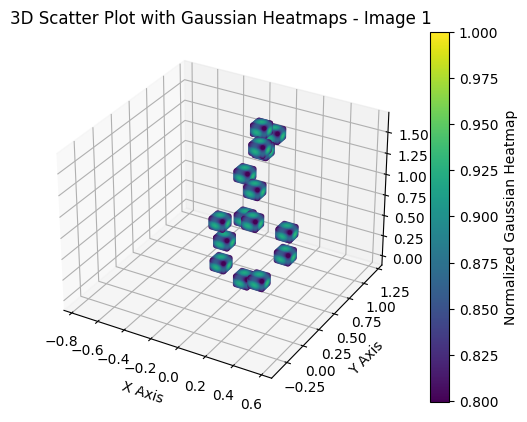

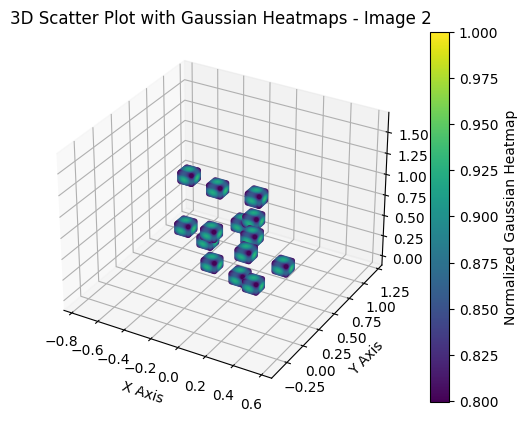

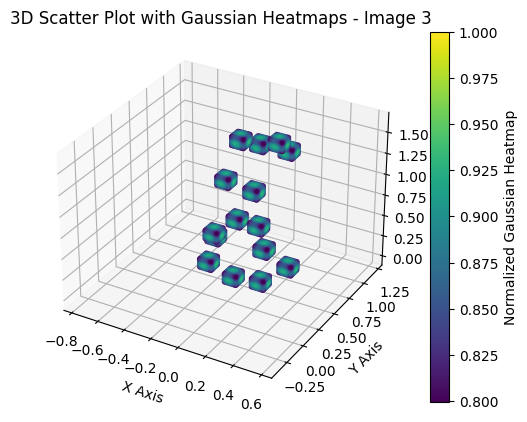

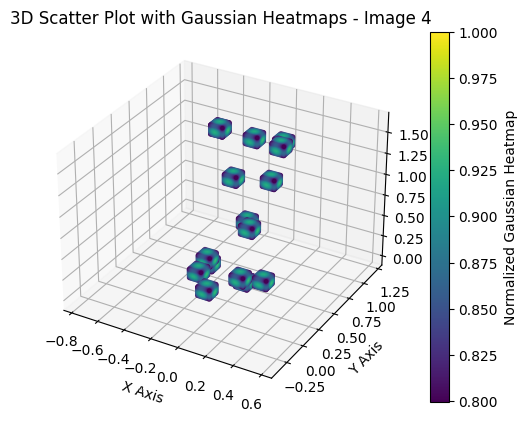

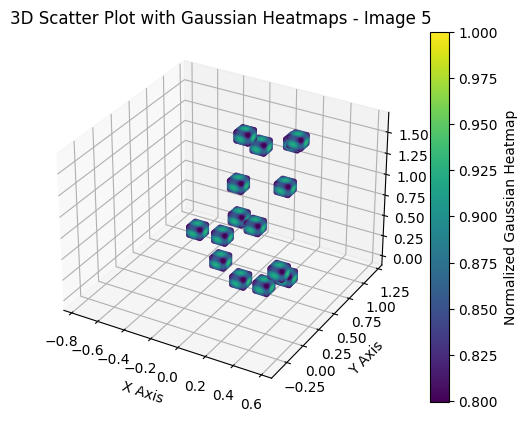

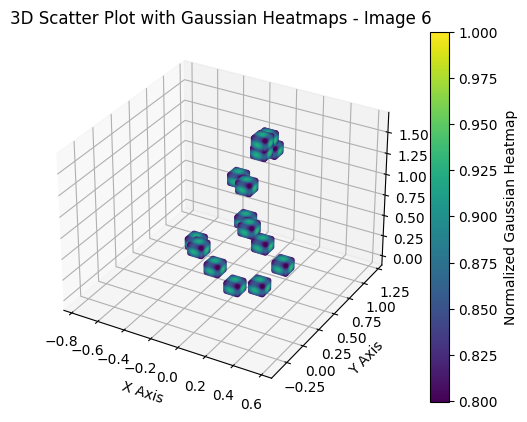

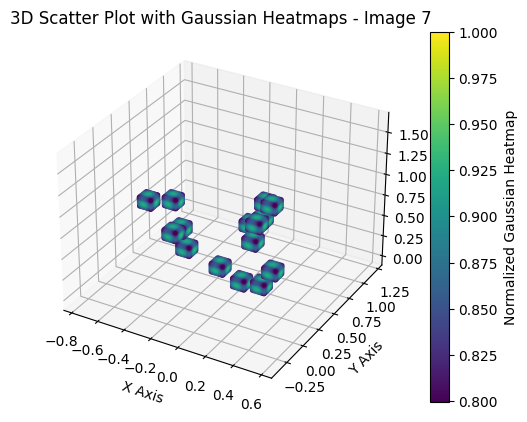

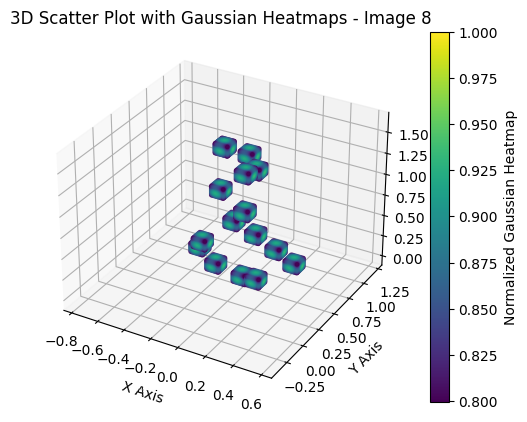

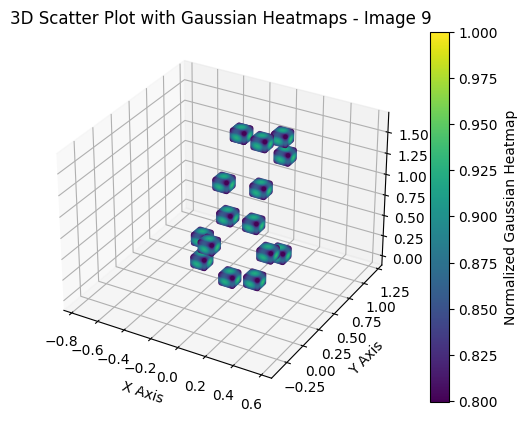

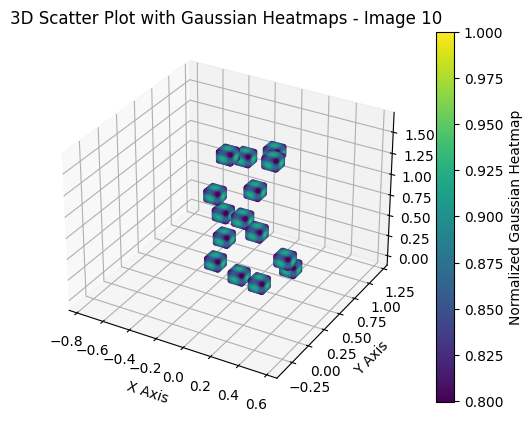

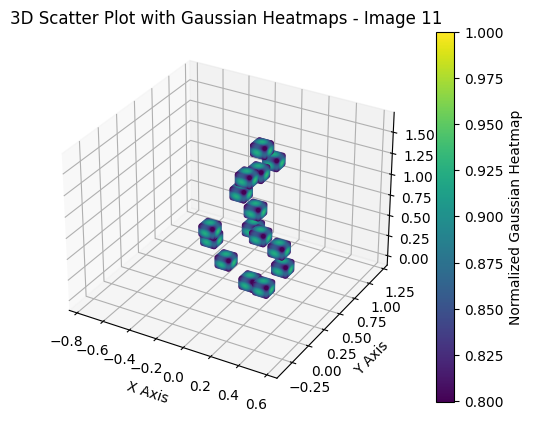

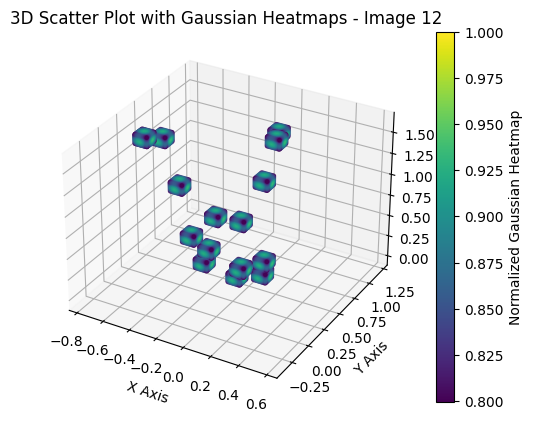

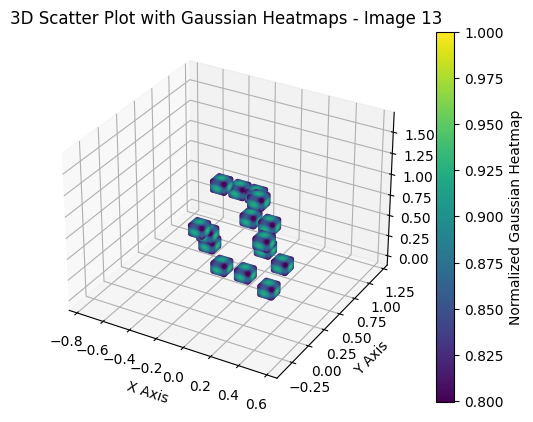

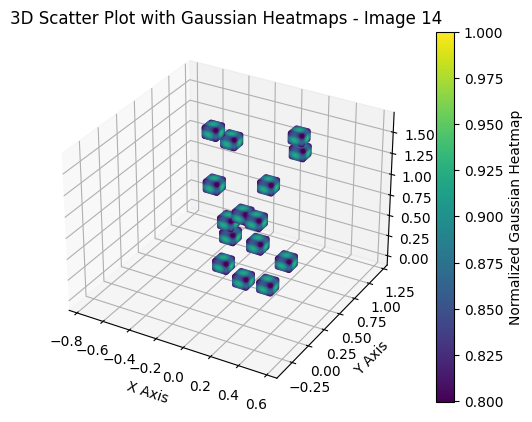

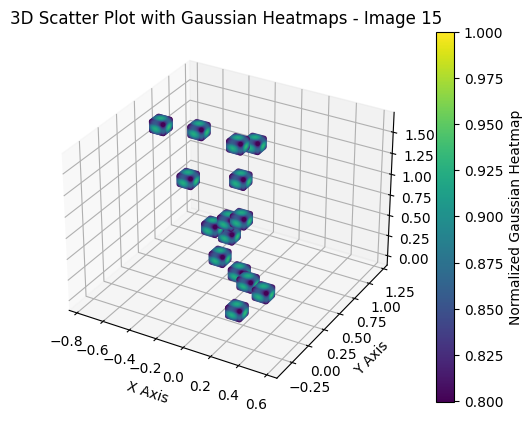

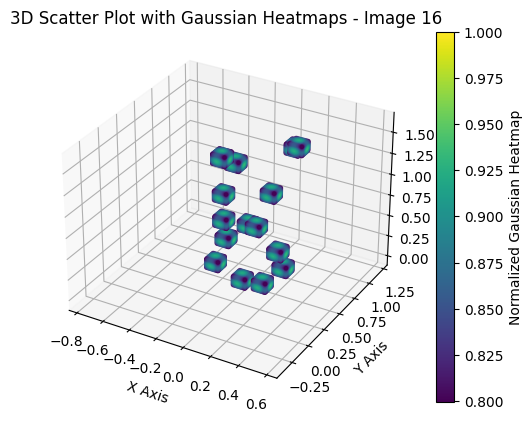

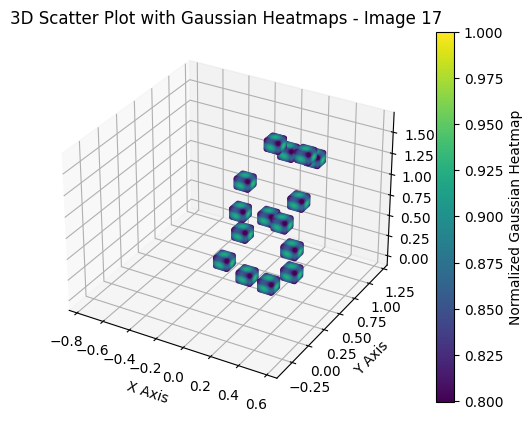

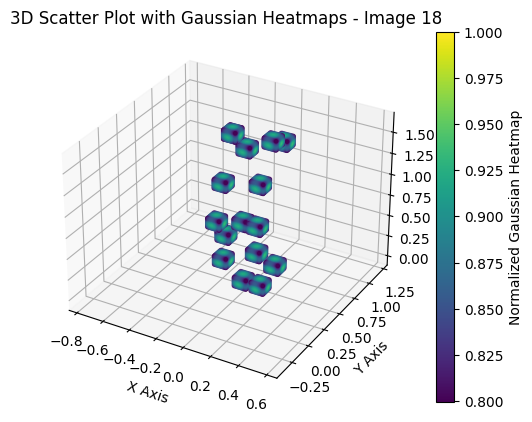

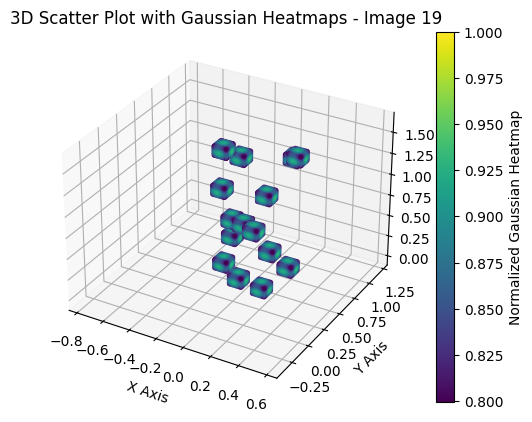

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import multivariate_normal

# Assuming outputs has shape (batch_size, 15, 3)
predicted_joints = outputs.view(-1, 15, 3).cpu().detach().numpy()
print(len(predicted_joints))

# Parameters for creating Gaussian heatmaps
num_points = 15
sigma_percentage = 1
sigma_x = (max_x - min_x) * (sigma_percentage / 100)
sigma_y = (max_y - min_y) * (sigma_percentage / 100)
sigma_z = (max_z - min_z) * (sigma_percentage / 100)

sigma = np.diag([sigma_x, sigma_y, sigma_z])

# Iterate through each example in the dataset
for example_index in range(predicted_joints.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'3D Scatter Plot with Gaussian Heatmaps - Image {example_index+1}')

    # Iterate through each joint
    for i in range(predicted_joints.shape[1]):
        joint_coords = predicted_joints[example_index, i]
        mean = joint_coords
        mvn = multivariate_normal(mean, sigma)

        # Create a grid of points
        x = np.linspace(mean[0] - 3 * sigma_x, mean[0] + 3 * sigma_x, num_points)
        y = np.linspace(mean[1] - 3 * sigma_y, mean[1] + 3 * sigma_y, num_points)
        z = np.linspace(mean[2] - 3 * sigma_z, mean[2] + 3 * sigma_z, num_points)
        xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

        # Evaluate the Gaussian distribution at each point in the grid
        heatmap = mvn.pdf(np.stack([xx, yy, zz], axis=-1))

        # Normalize the heatmap for better visualization
        heatmap = heatmap / heatmap.max()

        # Scatter plot for each joint
        ax.scatter(mean[0], mean[1], mean[2], marker='o', color='b', label=f'Joint {i+1}', s=50)
        ax.scatter(xx, yy, zz, c=heatmap, cmap='viridis', s=5)

    # Adjust the axis limits if needed
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_zlim(min_z, max_z)

    # Add labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')

    # Add a colorbar for the heatmap
    cbar = plt.colorbar(ax.scatter(xx, yy, zz, c=heatmap, cmap='viridis', s=5))
    cbar.set_label('Normalized Gaussian Heatmap')

    plt.show()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import multivariate_normal
